In [1]:
import os

from collections import defaultdict

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from Standard_functions import get_user_split_data, plot_fit_score_pred,fit_score_pred_G_NB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, f1_score
import copy

import warnings

warnings.filterwarnings('always') 

In [2]:
os.chdir('../Data/')

## Aisle Correlation categorical feature handling

In [3]:
df = pd.read_pickle('full_features')
df.drop(['max_order_number'],axis=1,inplace=True)

In [4]:
products = pd.read_csv('products.csv')

products.drop(['product_name','department_id'],axis=1,inplace=True)
aisle_and_target = df[['product_id','in_cart']].merge(products,on='product_id')

product_dummies = pd.get_dummies(aisle_and_target.aisle_id)
target = aisle_and_target['in_cart']

dummies_and_target = pd.DataFrame(target).merge(product_dummies,
                                       left_index=True,
                                       right_index=True)

out = defaultdict(list)
in_cart = dummies_and_target.in_cart
dummies_len = len(dummies_and_target.columns)

for i in range(1,dummies_len):
    dummy = dummies_and_target.loc[:,i]
    corr_dic = {'in_cart':in_cart,i:dummy}
    corr_df = pd.DataFrame(corr_dic).corr()

    out[i] = corr_df[i]['in_cart']*1000
    
aisles_corr = pd.DataFrame(out,index=range(0,1)).T.reset_index()
aisles_corr.columns = ['aisle_id','aisle_target_correlation']
pd.to_pickle(aisles_corr,'aisle_correlations_full_features')

In [5]:
aisles_corr = pd.read_pickle('aisle_correlations_full_features')
df = df.merge(products,on='product_id')
df = df.merge(aisles_corr,on='aisle_id')
df.drop(['aisle_id'],axis=1,inplace=True)

In [6]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df, val_size=.2, seed=42)
print('Gaussian Naive Bayes:')
fit_score_pred_G_NB(X_tr, X_val, y_tr, y_val)

Gaussian Naive Bayes:
Our f1-score is 0.4010307444325245
And we've predicted 1498674 non-re-orders and 205005 re-orders.


## ROC AUC

In [7]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)

In [8]:
clf = GaussianNB(var_smoothing=1e-9)
clf.fit(X_tr, y_tr)
probabilities = clf.predict_proba(X_val)[:,1]


In [9]:
fpr, tpr, thresholds = roc_curve(y_val,probabilities)

ROC AUC score =  0.7967907909648267


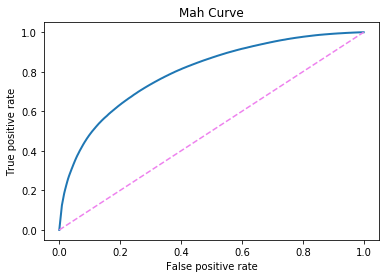

In [10]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Mah Curve');
print("ROC AUC score = ", roc_auc_score(y_val, probabilities))

## Messing with thresholds

In [11]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)

In [12]:
clf = GaussianNB(var_smoothing=1e-9)
clf.fit(X_tr, y_tr)
probabilities = clf.predict_proba(X_val)[:,1]


In [13]:
roc_auc_score(y_val,probabilities)

0.7967907909648267

In [14]:
fpr, tpr, thresholds = roc_curve(y_val,probabilities)

In [15]:
probs = pd.DataFrame(probabilities)
probs.columns = ['score']
test = copy.deepcopy(probs)

In [16]:
threshold = np.linspace(.1,.9,30)
dict_thresholdf1 = dict()

for i in threshold:
    test = copy.deepcopy(probs)
    conditions = [
    (test.score > i),
    (test.score < i)
    ]
    choices = [1,0]
    test.score = np.select(conditions, choices)
    dict_thresholdf1[i] = f1_score(y_val,test)

dict_thresholdf1

{0.1: 0.39140394040448206,
 0.12758620689655173: 0.39447240151622903,
 0.15517241379310345: 0.3963627842009889,
 0.1827586206896552: 0.3979673176564368,
 0.21034482758620693: 0.39915747164196413,
 0.23793103448275865: 0.3997948687749053,
 0.2655172413793104: 0.4004110761635546,
 0.2931034482758621: 0.40089559155383625,
 0.3206896551724138: 0.4010696549089519,
 0.34827586206896555: 0.40119410667181366,
 0.3758620689655173: 0.401300870450655,
 0.403448275862069: 0.4013452797248625,
 0.4310344827586208: 0.4012952511862122,
 0.45862068965517244: 0.4010698748704615,
 0.4862068965517242: 0.40108587370676585,
 0.5137931034482759: 0.4010660173160173,
 0.5413793103448277: 0.4008374177438788,
 0.5689655172413793: 0.40062924334311606,
 0.5965517241379311: 0.4003173567609707,
 0.6241379310344828: 0.4001225183081335,
 0.6517241379310346: 0.3997565538344174,
 0.6793103448275862: 0.39926680957666444,
 0.706896551724138: 0.3989352777406503,
 0.7344827586206897: 0.39835570133348613,
 0.7620689655172415